<a href="https://colab.research.google.com/github/tomPlus353/google-colab-notebooks/blob/main/%5Bpersonal%5Dhouse_price_neural_net(kaggle).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [21]:
#@title no. 1 setup project

In [22]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("nishiodens/japan-real-estate-transaction-prices")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'japan-real-estate-transaction-prices' dataset.
Path to dataset files: /kaggle/input/japan-real-estate-transaction-prices


In [23]:
#path from previous download
# path = "/root/.cache/kagglehub/datasets/nishiodens/japan-real-estate-transaction-prices/versions/1"

In [24]:
from google.colab import drive
drive.mount('/gdrive')
%cd ..
%ls

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/kaggle/input
japan-real-estate-transaction-prices/


In [25]:
%cd $path
%ls

/kaggle/input/japan-real-estate-transaction-prices
prefecture_code.csv  trade_prices/


In [26]:
!pip install tensorflow

In [27]:
#@title no. 2 build and save model

In [28]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import math

# load data
# Adding low_memory=False to help pandas infer types correctly from mixed columns
with open(f"{path}/trade_prices/04.csv") as f:
    data = pd.read_csv(f, low_memory=False)

# select categorical and numerical features
cat_cols = [
   'Municipality',
    'DistrictName',
            ]

num_cols = [
            'Area',
            'TotalFloorArea',
            'BuildingYear',
            'CoverageRatio',
            'FloorAreaRatio',
            'MaxTimeToNearestStation',
            'MinTimeToNearestStation',
            ]

# only target houses
data = data[data["Type"] == "Residential Land(Land and Building)"]

# Convert all specified numerical columns to numeric, coercing errors to NaN
# This ensures that these columns are properly numerical before calculating means.
for col in num_cols:
    data[col] = pd.to_numeric(data[col], errors='coerce')

# Fill missing numerical values with the mean of their respective columns
for col in num_cols:
    if data[col].isnull().any(): # Check if there are any NaNs to fill
        data[col] = data[col].fillna(data[col].mean())

# Fill missing categorical values with the mode of their respective columns
for col in cat_cols:
    if data[col].isnull().any(): # Check if there are any NaNs to fill
        mode_val = data[col].mode()
        if not mode_val.empty:
            data[col] = data[col].fillna(mode_val[0])
        else:
            # If mode is empty (e.g., all NaNs), fill with a placeholder string
            data[col] = data[col].fillna('Unknown')

# For any other object-type columns not in cat_cols, fill with 'Unknown'
# This handles other categorical columns that might have NaNs but are not part of cat_cols
for col in data.select_dtypes(include='object').columns:
    if col not in cat_cols and data[col].isnull().any():
        data[col] = data[col].fillna('Unknown')

# For any other numeric-type columns not in num_cols, fill with their mean
# This handles other numeric columns that might have NaNs but are not part of num_cols
for col in data.select_dtypes(include=np.number).columns:
    if col not in num_cols and data[col].isnull().any():
        data[col] = data[col].fillna(data[col].mean())


# # drop nan values
# data.dropna(subset=num_cols, inplace=True)

In [29]:

# check the data type of each column
print(data.dtypes)
print(data.describe)

data.head()

# # select rows 0 to 4 and columns 12, 26, and 3
#subset = data.iloc[0:5, [12, 26, 36]]

# # print the subset of data
#print(subset)

No                               int64
Type                            object
Region                          object
MunicipalityCode                 int64
Prefecture                      object
Municipality                    object
DistrictName                    object
NearestStation                  object
TimeToNearestStation            object
MinTimeToNearestStation        float64
MaxTimeToNearestStation        float64
TradePrice                       int64
FloorPlan                       object
Area                             int64
AreaIsGreaterFlag                int64
UnitPrice                      float64
PricePerTsubo                  float64
LandShape                       object
Frontage                       float64
FrontageIsGreaterFlag             bool
TotalFloorArea                 float64
TotalFloorAreaIsGreaterFlag      int64
BuildingYear                   float64
PrewarBuilding                   int64
Structure                       object
Use                      

,No,Type,Region,MunicipalityCode,Prefecture,Municipality,DistrictName,NearestStation,TimeToNearestStation,MinTimeToNearestStation,...,Classification,Breadth,CityPlanning,CoverageRatio,FloorAreaRatio,Period,Year,Quarter,Renovation,Remarks
2,3,Residential Land(Land and Building),Residential Area,4101,Miyagi Prefecture,"Aoba Ward,Sendai City",Aobamachi,Kitasendai,8,8.0,...,City Road,4.0,Category II Residential Zone,60.0,200.0,1st quarter 2018,2018,1,Unknown,Unknown
9,10,Residential Land(Land and Building),Residential Area,4101,Miyagi Prefecture,"Aoba Ward,Sendai City",Aobamachi,Kitasendai,8,8.0,...,Private Road,4.5,Category II Residential Zone,60.0,200.0,1st quarter 2015,2015,1,Unknown,Dealings including private road
11,12,Residential Land(Land and Building),Residential Area,4101,Miyagi Prefecture,"Aoba Ward,Sendai City",Akasaka,Ayashi,30-60minutes,30.0,...,City Road,6.0,Category I Exclusively Low-story Residential Zone,40.0,60.0,2nd quarter 2019,2019,2,Unknown,Unknown
13,14,Residential Land(Land and Building),Residential Area,4101,Miyagi Prefecture,"Aoba Ward,Sendai City",Akasaka,Ayashi,30-60minutes,30.0,...,City Road,16.0,Category I Residential Zone,60.0,200.0,1st quarter 2019,2019,1,Unknown,Unknown
15,16,Residential Land(Land and Building),Residential Area,4101,Miyagi Prefecture,"Aoba Ward,Sendai City",Akasaka,Ayashi,30-60minutes,30.0,...,City Road,16.0,Category I Residential Zone,60.0,200.0,3rd quarter 2018,2018,3,Unknown,Unknown


                             Area  TotalFloorArea  BuildingYear  \
Area                     1.000000        0.584216     -0.227761   
TotalFloorArea           0.584216        1.000000     -0.135320   
BuildingYear            -0.227761       -0.135320      1.000000   
CoverageRatio            0.154136        0.235321     -0.103564   
FloorAreaRatio           0.117991        0.309899     -0.083052   
MaxTimeToNearestStation  0.057138       -0.081506     -0.020527   
MinTimeToNearestStation  0.133151       -0.061568     -0.055991   

                         CoverageRatio  FloorAreaRatio  \
Area                          0.154136        0.117991   
TotalFloorArea                0.235321        0.309899   
BuildingYear                 -0.103564       -0.083052   
CoverageRatio                 1.000000        0.876879   
FloorAreaRatio                0.876879        1.000000   
MaxTimeToNearestStation      -0.394145       -0.406589   
MinTimeToNearestStation      -0.221981       -0.260359   

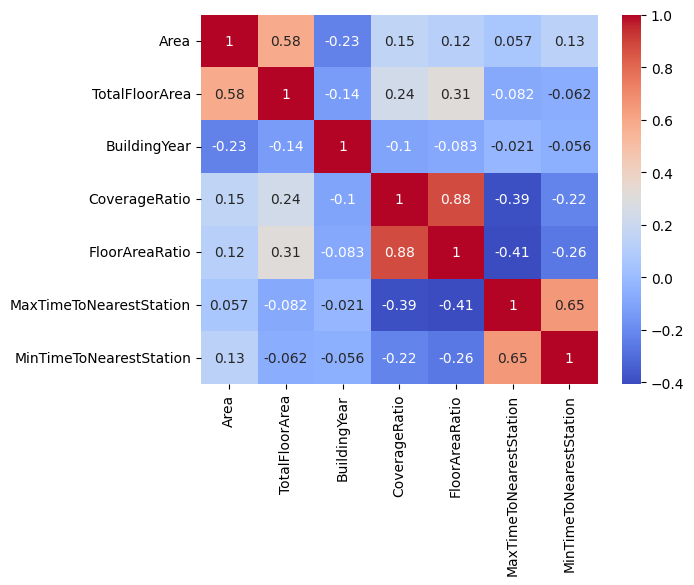

In [30]:
import seaborn as sns
import matplotlib.pyplot as plt


def showCorrelation(df, columns, target):
  #
  num_cols_with_target = columns.copy()
  num_cols_with_target.append(target)

  # calculate the correlation matrix for the selected columns
  corr_matrix = df[columns].corr()

  # print the correlation matrix
  print(corr_matrix)

  # visualize the correlation matrix using a heatmap
  sns.heatmap(corr_matrix, cmap='coolwarm', annot=True)

showCorrelation(data, num_cols,'TradePrice')
print(num_cols)

In [31]:
# for col in data.columns:
#     print(f"Unique values for column {col}:")
#     print(len(data[col].unique()))

In [32]:
## created new unique location including district and municipality
data['DistrictName2'] = data['DistrictName'].astype('str') + data['Municipality'].astype('str')
cat_cols.append('DistrictName2')

In [33]:
# for col in data.columns:
#     print(f"Unique values for column {col}:")
#     print(len(data[col].unique()))

In [34]:
checkpoint_path = "gdrive/MyDrive/Colab_Notebooks/training_1/cp.weights.h5"

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

# This may generate warnings related to saving the state of the optimizer.
# These warnings (and similar warnings throughout this notebook)
# are in place to discourage outdated usage, and can be ignored.

In [35]:
# one-hot encode categorical features
encoder = OneHotEncoder(handle_unknown='ignore')
encoder.fit(data[cat_cols])
encoded_cat = encoder.transform(data[cat_cols]).toarray()

# standardize numerical features
scaler = StandardScaler()
scaled_num = scaler.fit_transform(data[num_cols])

# combine encoded categorical and scaled numerical features
X = np.hstack((encoded_cat, scaled_num))

# define target variable
y = data['TradePrice']

# train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(X_train.shape)

(23212, 2743)


In [47]:
# define model
model = Sequential()
model.add(Dense(units=int(X_train.shape[1] / 2), activation='relu', input_shape=(X_train.shape[1],)))
model.add(Dropout(0.2))
model.add(Dense(units=int(X_train.shape[1] / 4), activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(units=int(X_train.shape[1] / 8), activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1))

# compile model
model.compile(loss='mae', optimizer='adam')

# early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=8, verbose=1)

# Train model
with tf.device('/GPU:0'):  # Use the first GPU
  model.fit(X_train,
            y_train,
            epochs=100,
            validation_data=(X_test, y_test),
            #callbacks=[early_stop, cp_callback]
            )

# evaluate model
mae = model.evaluate(X_test, y_test)
print(f"Mean absolute error: {mae:.2f}")


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
726/726 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - loss: 29309992.0000 - val_loss: 18230276.0000
Epoch 2/100
726/726 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 18240132.0000 - val_loss: 15896172.0000
Epoch 3/100
726/726 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 15606646.0000 - val_loss: 15146806.0000
Epoch 4/100
726/726 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 15192438.0000 - val_loss: 14857679.0000
Epoch 5/100
726/726 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 14005457.0000 - val_loss: 14712424.0000
Epoch 6/100
726/726 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 13639380.0000 - val_loss: 14559869.0000
Epoch 7/100
726/726 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 13126485.0000 - val_loss: 14479527.0000
Epoch 8/100
726/726 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 13778173.0000 - val_loss: 14406528.0000
Epoch 9/100
726/726 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 15029971.0000 - val_loss: 14323891.0000
Epoch 10/100
726/726 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 13798840.0000 - val_loss: 142

In [50]:
# plot_and_evaluate_cv
from sklearn.metrics import r2_score, median_absolute_error

#
y_pred = model.predict(X_test)


# Calculate Errors and Correlation
r2 = r2_score(y_test, y_pred)
mae = median_absolute_error(y_test, y_pred)
print(f"R-square (R2): {r2}")
print(f"Median absolute error: {mae}")


182/182 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
R-square (R2): 0.5241057872772217
Median absolute error: 3929008.0


In [38]:
avg = y.median()
print(f"Mean absolute error as percentage of median price: {(mae/avg)*100}%")

Mean absolute error as percentage of median price: 16.876995652173914%


In [39]:
#@title Insert Test Field
"""
cat_cols = [
   'Municipality',
    'DistrictName',
    'DistrictName2',
    # 'Region',
    # 'NearestStation',
    # 'CityPlanning',
            ]

num_cols = [
            'Area',
            'TotalFloorArea',
            'BuildingYear',
            'CoverageRatio',
            'FloorAreaRatio',
            'MaxTimeToNearestStation',
            'MinTimeToNearestStation',
            # 'Year',
            # 'Quarter',
            # 'Breadth',
            # 'Frontage',
            ]
"""
import ipywidgets as widgets

import pandas as pd

# Get unique values in a column as a list
options_city = data['Municipality'].unique().tolist()
options_district = data['DistrictName'].unique().tolist()


# Create a dropdown widget with options
dropdown_city = widgets.Dropdown(
    options=options_city,
    description='city:',

    )
dropdown_district = widgets.Dropdown(
    options=options_district,
    description='district name:',
    )
float_area = widgets.BoundedFloatText(
    value=None,
    min=10.0,
    max=1000.0,
    step=1.0,
    description='plot area square meters:',
    disabled=False
)
float_floor_area = widgets.BoundedFloatText(
    value=None,
    min=10.0,
    max=1000.0,
    step=1.0,
    description='floor area square meters:',
    disabled=False,
)

float_building_year = widgets.BoundedFloatText(
    value=None,
    min=10.0,
    max=2030.0,
    step=1.0,
    description='year built:',
    disabled=False
)
float_coverage_ratio = widgets.BoundedFloatText(
    value=None,
    min=10.0,
    max=1000.0,
    step=1.0,
    description='CoverageRatio:',
    disabled=False
)
float_floor_ratio = widgets.BoundedFloatText(
    value=None,
    min=10.0,
    max=1000.0,
    step=1.0,
    description='FloorAreaRatio:',
    disabled=False
)
float_maxTimeToNearestStation = widgets.BoundedFloatText(
    value=None,
    min=1.0,
    max=1000.0,
    step=1.0,
    description='max time to station:',
    disabled=False
)
float_minTimeToNearestStation = widgets.BoundedFloatText(
    value=None,
    min=1.0,
    max=1000.0,
    step=1.0,
    description='min time to station:',
    disabled=False
)
inputs = [
    dropdown_city,
    dropdown_district,
    float_area,
    float_floor_area,
    float_building_year,
    float_coverage_ratio,
    float_floor_ratio,
    float_maxTimeToNearestStation,
    float_minTimeToNearestStation,
]

# Display the dropdown widget
for i in inputs:
  label = widgets.Label(value=i.description)
  i.description = ""
  display(widgets.HBox([label, i]))

In [42]:

"""
Show result
"""
for i in inputs:
  print(f"The saved value is: {i.value}")



The saved value is: Izumi Ward,Sendai City
The saved value is: Minaminakayama
The saved value is: 225.09
The saved value is: 129.89
The saved value is: 1996.0
The saved value is: 40.0
The saved value is: 60.0
The saved value is: 21.0
The saved value is: 21.0


In [48]:
saved_user_test_case = {
    'Municipality': 'Izumi Ward,Sendai City',
    'DistrictName': 'Minaminakayama',
    'Area': 225.09,
    'TotalFloorArea': 129.89,
    'BuildingYear': 1996.0,
    'CoverageRatio': 40.0,
    'FloorAreaRatio': 60.0,
    'MaxTimeToNearestStation': 21.0,
    'MinTimeToNearestStation': 21.0
}

BoundedFloatText(value=21.0, max=1000.0, min=1.0, step=1.0)


In [2]:
import pandas as pd
import numpy as np
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Dense, Dropout

# Check if widgets are defined. If not, inform the user.
# This error typically means the preceding cell (HjUXujsXgy1e) defining the widgets was not run.
if 'dropdown_city' not in globals():
    print("Error: Interactive widgets are not defined. Please run the cell 'HjUXujsXgy1e' (the 'Insert Test Field' cell) first to define the input widgets.")
    raise NameError("Interactive widgets not defined. Please run the widget definition cell.")

# Assuming `data`, `cat_cols`, `num_cols`, `encoder`, and `scaler`
# are available from previous cells and are correctly fitted/defined.
# X_train.shape[1] was 2743 based on the output of cell g5wOionxsAKc.
# input_dim_for_model = 2743

# Create dataframe from inputted values
userTestDictionary = {
      'Municipality': [dropdown_city.value], # Wrap in list to create a DataFrame with one row
      'DistrictName': [dropdown_district.value],
      'Area': [float_area.value],
      'TotalFloorArea': [float_floor_area.value],
      'BuildingYear': [float_building_year.value],
      'CoverageRatio': [float_coverage_ratio.value],
      'FloorAreaRatio': [float_floor_ratio.value],
      'MaxTimeToNearestStation':[float_maxTimeToNearestStation.value],
      'MinTimeToNearestStation':[float_minTimeToNearestStation.value],
}
userTest = pd.DataFrame(userTestDictionary)

# Add 'DistrictName2' to userTest, consistent with previous preprocessing
userTest['DistrictName2'] = userTest['DistrictName'].astype('str') + userTest['Municipality'].astype('str')

# One-hot encode categorical features using the *already fitted* encoder
# `cat_cols` should contain 'DistrictName2' as well, as updated in cell ImkHU6CrF9IF
encoded_cat_user = encoder.transform(userTest[cat_cols]).toarray()

# Standardize numerical features using the *already fitted* scaler
scaled_num_user = scaler.transform(userTest[num_cols])

# Combine encoded categorical and scaled numerical features
X_usertest = np.hstack((encoded_cat_user, scaled_num_user))

# # Define model with the *exact same architecture* as the trained model in fzJYCx88OO9k
# model = Sequential()
# model.add(Dense(units=input_dim_for_model / 2, activation='relu', input_shape=(input_dim_for_model,)))
# model.add(Dropout(0.5))
# model.add(Dense(units=input_dim_for_model / 4, activation='relu'))
# model.add(Dropout(0.5))
# model.add(Dense(units=input_dim_for_model / 8, activation='relu'))
# model.add(Dropout(0.5))
# model.add(Dense(1))

# # Compile model with the same loss as training
# model.compile(loss='mae', optimizer='adam') # Use 'mae' as in training

# # Load saved weights (using the corrected checkpoint_path from the previous fix)
# checkpoint_path = "gdrive/MyDrive/Colab_Notebooks/training_1/cp.weights.h5"
# model.load_weights(checkpoint_path)

# Make predictions
y_usertest = model.predict(X_usertest)
print(f"Predicted price: {y_usertest[0][0]:,.2f} JPY")

Error: Interactive widgets are not defined. Please run the cell 'HjUXujsXgy1e' (the 'Insert Test Field' cell) first to define the input widgets.


NameError: Interactive widgets not defined. Please run the widget definition cell.